In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [88]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [89]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [90]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [91]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [92]:
data = data[data['FIPS'] != 'not county']

In [93]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [94]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [95]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [96]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str, 'Urban_Influence_Code_2013': str})

*Note: The urban influence code is not a smooth scale from 1 = most urban to 12 = least urban. It includes several categories of county — metropolitan, suburban, rural — and then ranks within each category. So it must be treted as categorical.*

In [97]:
population.columns = ['FIPS', 'urban_inf', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [98]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [99]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])
# increase in foreign population divided by the total population increase 

In [100]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [101]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,0.033898
5,01007,1,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [102]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [103]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,-0.033898
5,01007,1,22533,-0.016670,0.102094


In [104]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [105]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
unemployment = unemployment.set_index('FIPS')
unemployment2 = pd.read_excel('data/CLF01.xls', sheetname='Sheet9', usecols=['STCOU', 'CLF040210D'], converters={'STCOU': str})
unemployment2.columns = ['FIPS', 'unemployment_2009']
unemployment = unemployment.join(unemployment2.set_index('FIPS'))
unemployment['unemp_change'] = unemployment['unemployment'] - unemployment['unemployment_2009']
data = data.join(unemployment.drop('unemployment_2009', axis=1))

The features are the unemployment rate in 2014 and the change in that rate from 2009.

In [106]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
poverty = poverty.set_index('FIPS')
poverty2 = pd.read_excel('data/IPE01.xls', sheetname='Sheet5', usecols=['STCOU', 'IPE120209D'], converters={'STCOU': str})
poverty2.columns = ['FIPS', 'poverty_2009']
poverty = poverty.join(poverty2.set_index('FIPS'))
poverty['pov_change'] = poverty['poverty'] - poverty['poverty_2009']
data = data.join(poverty.drop('poverty_2009', axis=1))

Similarly, the poverty rate in 2014 and the change from 2009.

In [107]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [108]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [109]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [110]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [111]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [112]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [113]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [114]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [115]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [116]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [117]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [118]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [119]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [120]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [121]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [122]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [123]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [124]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [125]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [126]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [127]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [128]:
data.isnull().sum()

state             0
name              0
< diploma        10
degree+          10
urban_inf        10
pop_2014         10
pop_inc          10
foreign_inc      13
unemployment     11
unemp_change     13
poverty          13
median_hh_inc    13
pov_change       13
median_age        9
hh_afr_am        11
hh_hisp          11
hh_female        11
hh_food_st       11
foreign_07        9
vets             11
vets_male         9
viol_crime       18
prop_crime       18
dtype: int64

In [129]:
len(data.dropna())

3130

In [130]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [131]:
data = data.dropna()

In [132]:
(data == 0).sum()

state              0
name               0
< diploma          0
degree+            0
urban_inf          0
pop_2014           0
pop_inc            0
foreign_inc      156
unemployment       0
unemp_change      11
poverty            0
median_hh_inc      0
pov_change        61
median_age         0
hh_afr_am         85
hh_hisp            4
hh_female          2
hh_food_st         3
foreign_07        33
vets               0
vets_male          0
viol_crime       163
prop_crime       100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [133]:
data.describe()

,< diploma,degree+,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,poverty,median_hh_inc,pov_change,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,1.017577e+05,0.002831,0.395946,6.235559,2.946709,16.837380,47121.392971,-0.539904,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.263767e+05,0.041968,3.043823,2.256287,1.807379,6.422444,12099.573945,2.161624,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,8.900000e+01,-0.177510,-6.333333,1.200000,-8.200000,3.200000,21658.000000,-15.900000,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,1.102950e+04,-0.021689,0.007641,4.600000,1.700000,12.100000,38889.000000,-1.700000,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,2.574250e+04,-0.004227,0.057769,6.000000,2.800000,15.800000,45227.500000,-0.500000,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,6.785250e+04,0.020261,0.200482,7.500000,4.000000,20.400000,52529.750000,0.700000,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,1.007270e+07,0.727044,119.000000,24.000000,13.600000,47.400000,125635.000000,17.400000,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


From the stats, the dataset certainly contains strong outliers that will need to be dealt with.

In [134]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [135]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [136]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [137]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [138]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [139]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [140]:
data = data.join(targets.set_index('FIPS')) # drop na

In [141]:
data.isnull().sum()

state            0
name             0
< diploma        0
degree+          0
urban_inf        0
pop_2014         0
pop_inc          0
foreign_inc      0
unemployment     0
unemp_change     0
poverty          0
median_hh_inc    0
pov_change       0
median_age       0
hh_afr_am        0
hh_hisp          0
hh_female        0
hh_food_st       0
foreign_07       0
vets             0
vets_male        0
viol_crime       0
prop_crime       0
death_rate       4
numeric          4
dtype: int64

In [142]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_inf,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1,479488.0,0.085790,0.054824,5.7,4.5,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1,61706.0,0.104081,0.045556,4.2,3.7,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1,558519.0,0.044853,0.059893,4.6,4.0,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2,275584.0,0.090019,0.018015,4.5,5.7,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [143]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [144]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [145]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [146]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


Look at overall distribution of targets.

In [147]:
counts = pd.DataFrame(data.groupby(['state', 'numeric']).size())
counts.head()

0
state numeric   
AK    1.0      1
      5.0      1
      7.0      2
      11.0     2
      13.0     2

In [148]:
counts = counts.reset_index()
counts.columns = ['state', 'numeric', 'count']
counts['total'] = counts.apply(lambda row: counties_by_state.loc[row['state'], 'total'], axis=1)
counts['percent'] = counts['count'] / counts['total']
states = sorted(counts['state'].unique())

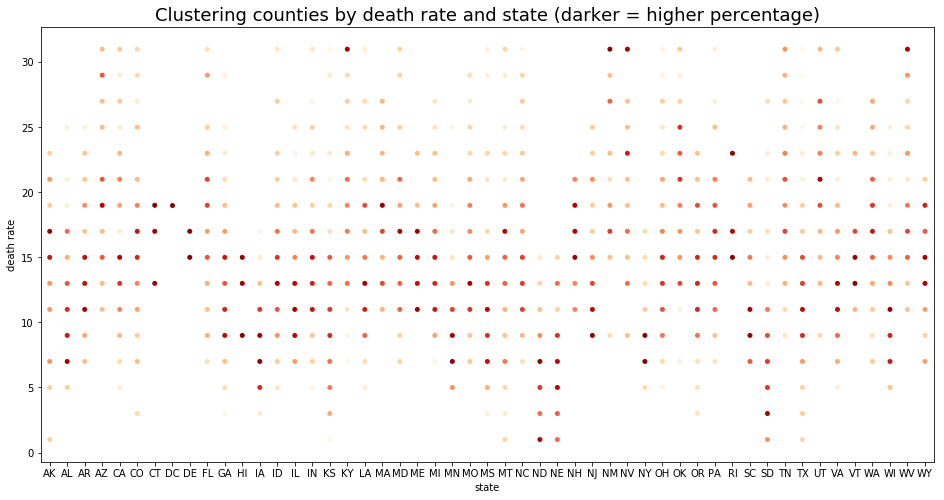

In [149]:
plt.rcParams["figure.figsize"] = [16.0, 8.0]
ax = sns.stripplot(data=counts, x='state', y='numeric', hue='percent', palette='OrRd')
ax.legend_.remove()
ax.set_title('Clustering counties by death rate and state (darker = higher percentage)', size=18)
ax.set_ylabel('death rate')
ax.figure.savefig('images/county_rates.png')

While there are some states with outlying concentrations of counties with low or high death rates, the distribution is fairly even overall.

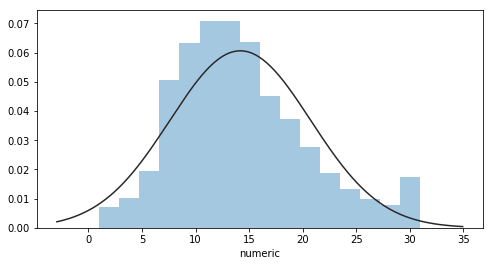

In [150]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = [8.0, 4.0]
target_hist = sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)
target_hist.figure.savefig('images/target_hist.png')

The target distribution is a little skewed but follows a roughly normal curve except for the spike at the highest value. Experimentation found that classification works better with these target outliers included, but the outliers in the predictors need to be dealt with.

In [151]:
data_raw = data.copy()
data = data.drop(['state', 'name', 'pop_2014'], axis=1)

In [152]:
bivariate = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.596235  0.185915     0.017175      0.444894   
degree+         0.596235  1.000000  0.437384     0.040137      0.344505   
pop_inc         0.185915  0.437384  1.000000     0.003214      0.265479   
foreign_inc     0.017175  0.040137  0.003214     1.000000      0.006487   
unemployment    0.444894  0.344505  0.265479     0.006487      1.000000   
unemp_change    0.099960  0.104568  0.019885     0.001546      0.183943   
poverty         0.676247  0.454771  0.279422     0.016851      0.615135   
median_hh_inc   0.555187  0.682043  0.471092     0.020453      0.472713   
pov_change      0.026931  0.041624  0.043384     0.000316      0.183201   
median_age      0.207144  0.180067  0.366550     0.037000      0.045748   
hh_afr_am       0.337359  0.078255  0.089242     0.001260      0.393471   
hh_hisp         0.416976  0.014507  0.157683     0.001310      0.007594   
hh_female       0.535661 

**poverty** correlates strongly with several other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [153]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

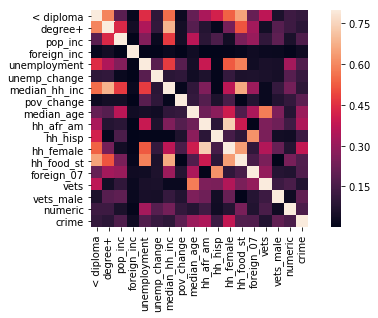

In [154]:
corrmat = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
heatmap = sns.heatmap(corrmat, vmax=.8, square=True)
heatmap.figure.savefig('images/heatmap.png')

There are other correlations, but variance inflation factor (VIF) analysis will be used to determine which should be removed. But first look at outliers in the independent variables.

In [155]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [156]:
outliers = get_outliers(data.drop(['urban_inf', 'death_rate', 'numeric'], axis=1))
len(data[outliers.any(axis=1)])

1499

In [157]:
extreme_outliers = get_outliers(data.drop(['urban_inf', 'death_rate', 'numeric'], axis=1), 2.5)
len(data[extreme_outliers.any(axis=1)])

927

In [158]:
xx_outliers = list((data[extreme_outliers.sum(axis=1) > 1]).index)
len(xx_outliers)

273

Almost half the dataset contains outliers, and more than a quarter contains extreme outliers that are more than 2.5 times the IQR below the first quartile or above the third. As an alternative to dropping a large number of samples, apply robust scaling to the predictors. Scikit-learn has two solutions, robust scaling and quantile transformation. Try them both. If necessary drop the most extreme (xx) outliers, those samples having more than one extreme outlier.

*Note: Having gone through the same iterative process as the notebook on the master branch and not achieving significantly better results, the data will be split from the outset to produce balanced train/test sets with respect to high/low death rates, with high being 15 or greater, and low being 13 or less. This will have the desired effect only for the last, binary, classification attempt, as the intermediary classifications into 16, 8 and 4 classes will no longer be stratified according to the progressive grouping scheme.*

In [159]:
from sklearn.model_selection import train_test_split

data['high_death_rate'] = np.where(data['numeric'] < 15, 0, 1)
data_train, data_test, targets_train, targets_test = train_test_split(data.drop('death_rate', axis=1),
                                                                     data['death_rate'], test_size=.2,
                                                                     stratify=data['high_death_rate'], random_state=13)

In [160]:
print(len(data_train[data_train['high_death_rate'] == 0]), len(data_train[data_train['high_death_rate'] == 1]))
print(len(data_test[data_test['high_death_rate'] == 0]), len(data_test[data_test['high_death_rate'] == 1]))

1371 1129
343 283


It is necessary to separate the training and test data before scaling/transforming to prevent data leakage from the test data when fitting the scaling and transformation algorithms. 

In [161]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer
robust = RobustScaler()
quantile = QuantileTransformer()

r_train = pd.DataFrame(robust.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
r_train['urban_inf'] = data_train['urban_inf']

q_train = pd.DataFrame(quantile.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
q_train['urban_inf'] = data_train['urban_inf']

*Note: Both robust scaling and quantile transformation leave binary features unchanged, so __urban_inf__ will be one-hot encoded later.*

Use VIF analysis to programmatically eliminate the variables with the highest VIF scores.

In [162]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
remove = ['urban_inf', 'numeric', 'high_death_rate']
features = r_train.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,4.373346,< diploma
1,3.102136,degree+
2,1.635238,pop_inc
3,1.008715,foreign_inc
4,1.950713,unemployment
5,1.076284,unemp_change
6,2.967300,median_hh_inc
7,1.137061,pov_change
8,2.286735,median_age
9,2.687256,hh_afr_am


In [163]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = r_train.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
    
r_features = list(features.columns) + ['urban_inf']
vif

,VIF,features
0,1.389071,degree+
1,1.386369,pop_inc
2,1.006899,foreign_inc
3,1.466743,unemployment
4,1.055496,unemp_change
5,1.091065,pov_change
6,1.503962,hh_afr_am
7,1.120092,hh_hisp
8,1.152088,vets
9,1.198796,vets_male


In [164]:
vif2 = pd.DataFrame()
remove = ['urban_inf', 'numeric', 'high_death_rate']
features2 = q_train.drop(remove, axis=1)
vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
vif2["features"] = features2.columns
vif2

,VIF,features
0,13.402615,< diploma
1,11.360647,degree+
2,7.134452,pop_inc
3,5.359084,foreign_inc
4,8.244911,unemployment
5,4.507403,unemp_change
6,9.733576,median_hh_inc
7,4.339483,pov_change
8,9.414736,median_age
9,9.547267,hh_afr_am


In [165]:
max_VIF = max(vif2['VIF'])
while len(vif2) > 11:
    remove = remove + list(vif2[vif2['VIF'] == max_VIF]['features'])
    features2 = q_train.drop(remove, axis=1)
    vif2 = pd.DataFrame()
    vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
    vif2["features"] = features2.columns
    max_VIF = max(vif2['VIF'])

q_features = list(features2.columns) + ['urban_inf']   
vif2

,VIF,features
0,5.858493,degree+
1,5.751327,pop_inc
2,5.076685,foreign_inc
3,5.476430,unemployment
4,4.273719,unemp_change
5,3.538461,pov_change
6,6.185417,hh_afr_am
7,5.411258,hh_hisp
8,3.830490,vets
9,3.495463,vets_male


Although the VIF scores were higher with the quantile-transformed data, the order was the same, so proceed with the 11 features from the scaled data that scored below 2.

Try a range of classifiers. 

In [166]:
Xr1_train = r_train.loc[:, r_features]
Xr1_train = pd.get_dummies(Xr1_train, prefix='urb_inf_', columns=['urban_inf'])
Yr1_train = targets_train

Xq1_train = q_train.loc[:, r_features]
Xq1_train = pd.get_dummies(Xq1_train, prefix='urb_inf_', columns=['urban_inf'])
Yq1_train = targets_train

In [167]:
from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [168]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [169]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(class_weight='balanced', tol=1e-3)
rfc = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

In [170]:
classifiers = [lrc, gbc, sgd, rfc, svc, knn]
names = ['lrc', 'gbc', 'sgd', 'rfc', 'svc', 'knn']
full_names = {'lrc':'Logistic regression', 'gbc':'Gradient boosting', 'sgd':'Stochastic gradient descent',
              'rfc':'Random forest', 'svc':'Support vector', 'knn':'K-Nearest neighbors'}

index = pd.MultiIndex.from_product([['Y16', 'Y8', 'Y4', 'Y2'], ['r', 'q'], [1, 2]])
results = pd.DataFrame(index=index, columns=names)

def run_trials(X, Y, targets, scale, feature_set):
    for name, clf in zip(names, classifiers):
        scores = cross_val_score(clf, X, Y, cv=5, scoring=matthews)
        results.loc[targets, scale, feature_set][name] = np.mean(scores)
        %time print('{} scores: {}'.format(full_names[name], scores))

In [171]:
run_trials(Xr1_train, Yr1_train, 'Y16', 'r', 1)

Logistic regression scores: [ 0.05315599  0.05556943  0.06444637  0.04198675  0.07011897]
CPU times: user 1.65 ms, sys: 113 µs, total: 1.76 ms
Wall time: 440 µs
Gradient boosting scores: [ 0.07611197  0.06500378  0.08015024  0.04731559  0.07278077]
CPU times: user 365 µs, sys: 52 µs, total: 417 µs
Wall time: 402 µs
Stochastic gradient descent scores: [ 0.04302945  0.00330357  0.01909361  0.04156341  0.05592828]
CPU times: user 1.47 ms, sys: 92 µs, total: 1.57 ms
Wall time: 392 µs
Random forest scores: [ 0.04197358  0.04730799  0.03978676  0.07168514  0.05451942]
CPU times: user 367 µs, sys: 53 µs, total: 420 µs
Wall time: 404 µs
Support vector scores: [ 0.07117561  0.08622946  0.07061263  0.09856212  0.08473546]
CPU times: user 402 µs, sys: 53 µs, total: 455 µs
Wall time: 444 µs
K-Nearest neighbors scores: [ 0.0420281   0.03601487  0.04234999  0.03835727  0.07488866]
CPU times: user 351 µs, sys: 33 µs, total: 384 µs
Wall time: 389 µs


All of the stock classifiers performed poorly, with support vector doing the best, followed by gradient boosting and logistic regression.

In [172]:
run_trials(Xq1_train, Yq1_train, 'Y16', 'q', 1)

Logistic regression scores: [ 0.05717304  0.04486477  0.0635689   0.03054269  0.07005875]
CPU times: user 1.54 ms, sys: 83 µs, total: 1.63 ms
Wall time: 403 µs
Gradient boosting scores: [ 0.09261297  0.07007983  0.06237495  0.05813191  0.07060044]
CPU times: user 369 µs, sys: 62 µs, total: 431 µs
Wall time: 405 µs
Stochastic gradient descent scores: [ 0.03681979  0.01863433  0.04505155  0.01536453  0.04906625]
CPU times: user 1.81 ms, sys: 173 µs, total: 1.99 ms
Wall time: 515 µs
Random forest scores: [ 0.06431237  0.04305649  0.03337741  0.05796603  0.05730611]
CPU times: user 365 µs, sys: 62 µs, total: 427 µs
Wall time: 406 µs
Support vector scores: [ 0.04360361  0.0377379   0.04886285  0.0576621   0.05097247]
CPU times: user 357 µs, sys: 54 µs, total: 411 µs
Wall time: 395 µs
K-Nearest neighbors scores: [ 0.02792726  0.01254466  0.0115488   0.02477701  0.0418932 ]
CPU times: user 336 µs, sys: 33 µs, total: 369 µs
Wall time: 375 µs


The quantile-transformed data performed even worse. Try an alternative selection process starting with correlations with the target variable.

In [173]:
bivariate = r_train.drop(['urban_inf', 'high_death_rate'], axis=1).corr().abs()
bivariate.loc['numeric'].drop('numeric')

< diploma        0.129802
degree+          0.108880
pop_inc          0.046599
foreign_inc      0.002281
unemployment     0.334084
unemp_change     0.162174
median_hh_inc    0.240524
pov_change       0.097301
median_age       0.070081
hh_afr_am        0.138424
hh_hisp          0.032536
hh_female        0.078814
hh_food_st       0.249716
foreign_07       0.060102
vets             0.132303
vets_male        0.034855
crime            0.159208
Name: numeric, dtype: float64

In [174]:
features2 = list(bivariate[bivariate.loc['numeric'] > .05].drop('numeric').index)

In [175]:
vif = pd.DataFrame()
features = r_train.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,3.949988,< diploma
1,3.012560,degree+
2,1.886529,unemployment
3,1.067913,unemp_change
4,2.743970,median_hh_inc
5,1.109437,pov_change
6,1.929993,median_age
7,2.521036,hh_afr_am
8,3.830212,hh_female
9,3.382855,hh_food_st


In [176]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = r_train.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,1.352025,degree+
1,1.439612,unemployment
2,1.058117,unemp_change
3,1.080741,pov_change
4,1.736407,median_age
5,1.420526,hh_afr_am
6,1.296802,foreign_07
7,1.631301,vets
8,1.318287,crime


In [177]:
features2 = list(vif['features']) + ['urban_inf']
Xr2_train = r_train.loc[:, features2]
Xr2_train = pd.get_dummies(Xr2_train, prefix='urb_inf_', columns=['urban_inf'])
Yr2_train = targets_train

Xq2_train = q_train.loc[:, (features2)]
Xq2_train = pd.get_dummies(Xq2_train, prefix='urb_inf_', columns=['urban_inf'])
Yq2_train = targets_train

In [178]:
run_trials(Xr2_train, Yr2_train, 'Y16', 'r', 2)

Logistic regression scores: [ 0.08120245  0.03837602  0.05937706  0.05447471  0.05991573]
CPU times: user 1.95 ms, sys: 148 µs, total: 2.1 ms
Wall time: 518 µs
Gradient boosting scores: [ 0.0578296   0.07202416  0.07853071  0.08820188  0.09242876]
CPU times: user 374 µs, sys: 55 µs, total: 429 µs
Wall time: 412 µs
Stochastic gradient descent scores: [ 0.04218024  0.02599531  0.02731509  0.05121356  0.0466855 ]
CPU times: user 1.75 ms, sys: 100 µs, total: 1.85 ms
Wall time: 468 µs
Random forest scores: [ 0.02521866  0.06133552  0.06087013  0.03661739  0.0849586 ]
CPU times: user 355 µs, sys: 60 µs, total: 415 µs
Wall time: 398 µs
Support vector scores: [ 0.11107941  0.08165667  0.06313725  0.08311447  0.09857294]
CPU times: user 379 µs, sys: 48 µs, total: 427 µs
Wall time: 413 µs
K-Nearest neighbors scores: [ 0.03706683  0.05379337  0.03768774  0.0268804   0.07501976]
CPU times: user 356 µs, sys: 42 µs, total: 398 µs
Wall time: 392 µs


In [179]:
run_trials(Xq2_train, Yq2_train, 'Y16', 'q', 2)

Logistic regression scores: [ 0.05159557  0.05399451  0.04969197  0.05483237  0.07949733]
CPU times: user 1.59 ms, sys: 117 µs, total: 1.7 ms
Wall time: 424 µs
Gradient boosting scores: [ 0.04096782  0.06850544  0.06639818  0.05542493  0.0810068 ]
CPU times: user 361 µs, sys: 58 µs, total: 419 µs
Wall time: 401 µs
Stochastic gradient descent scores: [ 0.03367121  0.02808361  0.05417985  0.03416615  0.05426133]
CPU times: user 1.48 ms, sys: 209 µs, total: 1.69 ms
Wall time: 454 µs
Random forest scores: [ 0.05808162  0.04379346  0.05320007  0.0709287   0.06772565]
CPU times: user 368 µs, sys: 65 µs, total: 433 µs
Wall time: 410 µs
Support vector scores: [ 0.04706307  0.04402198  0.05096395  0.05731853  0.0712891 ]
CPU times: user 365 µs, sys: 54 µs, total: 419 µs
Wall time: 405 µs
K-Nearest neighbors scores: [ 0.04165052  0.03389312  0.05255951  0.0518747   0.05721658]
CPU times: user 355 µs, sys: 54 µs, total: 409 µs
Wall time: 396 µs


The scores are very close for both training sets, but also very poor. Try combining targets to make fewer classes.

In [180]:
def combine_targets(input):
    targets = sorted(input.unique(), key=lambda x: int(re.search('\d+(?=-)', x).group()))
    first = []
    second = []
    for i, r in enumerate(targets):
        first.append(r) if i % 2 == 0 else second.append(r)
    if len(first) != len(second):
        second.append('30-31.9')
    conversions = {}
    for start, end in zip(first, second):
        new_value = re.search('\d+-', start).group() + re.search('(?<=-)\d+.\d+', end).group()
        conversions.update(dict.fromkeys([start, end], new_value))
    return input.apply(lambda x: conversions[x])

In [181]:
Y_16_train = targets_train.apply(lambda x: '0-1.9' if x == '<2' else x)
Y_16_train = Y_16_train.apply(lambda x: '30-31.9' if x == '30+' else x)

Y_8_train = combine_targets(Y_16_train)


In [182]:
run_trials(Xr1_train, Y_8_train, 'Y8', 'r', 1)

Logistic regression scores: [ 0.1006998   0.15027161  0.13541833  0.12946323  0.1468057 ]
CPU times: user 1.53 ms, sys: 90 µs, total: 1.62 ms
Wall time: 404 µs
Gradient boosting scores: [ 0.12534395  0.1394993   0.13796789  0.16733632  0.13505036]
CPU times: user 357 µs, sys: 51 µs, total: 408 µs
Wall time: 400 µs
Stochastic gradient descent scores: [ 0.06754528  0.07694622  0.02703655  0.06925516  0.06381313]
CPU times: user 1.98 ms, sys: 142 µs, total: 2.12 ms
Wall time: 539 µs
Random forest scores: [ 0.07869024  0.094455    0.07150314  0.12568501  0.08009405]
CPU times: user 407 µs, sys: 48 µs, total: 455 µs
Wall time: 444 µs
Support vector scores: [ 0.11206608  0.161711    0.12389991  0.16337382  0.15331281]
CPU times: user 350 µs, sys: 49 µs, total: 399 µs
Wall time: 388 µs
K-Nearest neighbors scores: [ 0.12779606  0.0575085   0.11942509  0.12490683  0.14238761]
CPU times: user 340 µs, sys: 45 µs, total: 385 µs
Wall time: 378 µs


In [183]:
run_trials(Xr2_train, Y_8_train, 'Y8', 'r', 2)

Logistic regression scores: [ 0.09360022  0.13562208  0.1233944   0.12577249  0.15457289]
CPU times: user 2.64 ms, sys: 217 µs, total: 2.85 ms
Wall time: 716 µs
Gradient boosting scores: [ 0.12878063  0.11656372  0.1580382   0.17077499  0.11328863]
CPU times: user 351 µs, sys: 53 µs, total: 404 µs
Wall time: 393 µs
Stochastic gradient descent scores: [ 0.08739809  0.12577556  0.02927808  0.09727602  0.06426306]
CPU times: user 1.47 ms, sys: 73 µs, total: 1.54 ms
Wall time: 389 µs
Random forest scores: [ 0.11714984  0.08679261  0.11805901  0.17555753  0.08078775]
CPU times: user 350 µs, sys: 58 µs, total: 408 µs
Wall time: 392 µs
Support vector scores: [ 0.16068255  0.14482644  0.14215889  0.16919535  0.17270301]
CPU times: user 369 µs, sys: 48 µs, total: 417 µs
Wall time: 402 µs
K-Nearest neighbors scores: [ 0.11159673  0.12634983  0.1460032   0.08832114  0.16423142]
CPU times: user 344 µs, sys: 33 µs, total: 377 µs
Wall time: 381 µs


In [184]:
run_trials(Xq1_train, Y_8_train, 'Y8', 'q', 1)

Logistic regression scores: [ 0.12324073  0.12032059  0.11303426  0.11163933  0.14577892]
CPU times: user 2.17 ms, sys: 147 µs, total: 2.32 ms
Wall time: 577 µs
Gradient boosting scores: [ 0.1495902   0.12201512  0.13407788  0.18345761  0.118893  ]
CPU times: user 431 µs, sys: 59 µs, total: 490 µs
Wall time: 457 µs
Stochastic gradient descent scores: [ 0.08049973  0.05045913  0.06750357  0.06327452  0.07483666]
CPU times: user 1.79 ms, sys: 146 µs, total: 1.93 ms
Wall time: 495 µs
Random forest scores: [ 0.11473847  0.10931723  0.13162613  0.16283369  0.13639455]
CPU times: user 406 µs, sys: 57 µs, total: 463 µs
Wall time: 443 µs
Support vector scores: [ 0.11883457  0.10128429  0.12849027  0.1018431   0.13720605]
CPU times: user 351 µs, sys: 52 µs, total: 403 µs
Wall time: 386 µs
K-Nearest neighbors scores: [ 0.105686    0.04634389  0.08640223  0.11473222  0.07343662]
CPU times: user 359 µs, sys: 49 µs, total: 408 µs
Wall time: 394 µs


In [185]:
run_trials(Xq2_train, Y_8_train, 'Y8', 'q', 2)

Logistic regression scores: [ 0.11035675  0.1216532   0.11400994  0.1322087   0.15385866]
CPU times: user 1.52 ms, sys: 83 µs, total: 1.61 ms
Wall time: 402 µs
Gradient boosting scores: [ 0.1357925   0.1198578   0.15917184  0.15856403  0.13064018]
CPU times: user 371 µs, sys: 59 µs, total: 430 µs
Wall time: 414 µs
Stochastic gradient descent scores: [ 0.11131471  0.08832688  0.0919509   0.07774446  0.08442544]
CPU times: user 1.52 ms, sys: 82 µs, total: 1.6 ms
Wall time: 399 µs
Random forest scores: [ 0.12150031  0.09239171  0.14316362  0.12511428  0.09019158]
CPU times: user 390 µs, sys: 56 µs, total: 446 µs
Wall time: 429 µs
Support vector scores: [ 0.11023528  0.12328048  0.08497923  0.11620102  0.16563487]
CPU times: user 354 µs, sys: 50 µs, total: 404 µs
Wall time: 392 µs
K-Nearest neighbors scores: [ 0.07821737  0.06529068  0.12167276  0.12566131  0.11773391]
CPU times: user 355 µs, sys: 54 µs, total: 409 µs
Wall time: 395 µs


There was significant improvement, but performance is still poor. Try reducing to 4 classes.

In [186]:
Y_4_train = combine_targets(Y_8_train)

In [187]:
run_trials(Xr1_train, Y_4_train, 'Y4', 'r', 1)

Logistic regression scores: [ 0.25462875  0.22164089  0.27185536  0.2518097   0.2610493 ]
CPU times: user 1.99 ms, sys: 148 µs, total: 2.13 ms
Wall time: 530 µs
Gradient boosting scores: [ 0.28744073  0.16810738  0.31441484  0.23221504  0.26598883]
CPU times: user 341 µs, sys: 54 µs, total: 395 µs
Wall time: 381 µs
Stochastic gradient descent scores: [ 0.12611683  0.11996962  0.14853822  0.2092378   0.11860756]
CPU times: user 1.53 ms, sys: 82 µs, total: 1.61 ms
Wall time: 403 µs
Random forest scores: [ 0.20058334  0.1690704   0.2521197   0.26637122  0.14069948]
CPU times: user 350 µs, sys: 57 µs, total: 407 µs
Wall time: 391 µs
Support vector scores: [ 0.28030463  0.23405757  0.28216966  0.26609776  0.26125599]
CPU times: user 352 µs, sys: 51 µs, total: 403 µs
Wall time: 391 µs
K-Nearest neighbors scores: [ 0.26297784  0.15598445  0.21257458  0.21811632  0.26948666]
CPU times: user 406 µs, sys: 34 µs, total: 440 µs
Wall time: 444 µs


In [188]:
run_trials(Xr2_train, Y_4_train, 'Y4', 'r', 2)

Logistic regression scores: [ 0.25587575  0.21260522  0.26961122  0.26027286  0.22438117]
CPU times: user 1.52 ms, sys: 84 µs, total: 1.61 ms
Wall time: 400 µs
Gradient boosting scores: [ 0.25800566  0.21143096  0.34840676  0.26782256  0.25395302]
CPU times: user 357 µs, sys: 57 µs, total: 414 µs
Wall time: 404 µs
Stochastic gradient descent scores: [ 0.20517322  0.07963736  0.22751317  0.24957544  0.20038597]
CPU times: user 1.46 ms, sys: 77 µs, total: 1.54 ms
Wall time: 385 µs
Random forest scores: [ 0.24376364  0.17804801  0.25711117  0.23103077  0.15524245]
CPU times: user 375 µs, sys: 62 µs, total: 437 µs
Wall time: 415 µs
Support vector scores: [ 0.31135434  0.22896785  0.30134528  0.26801159  0.27662481]
CPU times: user 355 µs, sys: 58 µs, total: 413 µs
Wall time: 392 µs
K-Nearest neighbors scores: [ 0.21139027  0.17011536  0.27060003  0.20758693  0.19872743]
CPU times: user 339 µs, sys: 45 µs, total: 384 µs
Wall time: 376 µs


In [189]:
run_trials(Xq1_train, Y_4_train, 'Y4', 'q', 1)

Logistic regression scores: [ 0.26329733  0.20647624  0.21324231  0.25195228  0.24772061]
CPU times: user 1.5 ms, sys: 87 µs, total: 1.59 ms
Wall time: 395 µs
Gradient boosting scores: [ 0.24516282  0.19130749  0.29527734  0.23348608  0.23539317]
CPU times: user 360 µs, sys: 56 µs, total: 416 µs
Wall time: 399 µs
Stochastic gradient descent scores: [ 0.1921939   0.1714345   0.19761616  0.25628389  0.19592774]
CPU times: user 1.53 ms, sys: 82 µs, total: 1.61 ms
Wall time: 402 µs
Random forest scores: [ 0.21427997  0.15660186  0.26221277  0.22633231  0.19003522]
CPU times: user 350 µs, sys: 55 µs, total: 405 µs
Wall time: 390 µs
Support vector scores: [ 0.25980482  0.18858476  0.2312886   0.21470175  0.23107024]
CPU times: user 370 µs, sys: 53 µs, total: 423 µs
Wall time: 407 µs
K-Nearest neighbors scores: [ 0.17416892  0.20302127  0.1294307   0.16892895  0.16185769]
CPU times: user 366 µs, sys: 36 µs, total: 402 µs
Wall time: 406 µs


In [190]:
run_trials(Xq2_train, Y_4_train, 'Y4', 'q', 2)

Logistic regression scores: [ 0.23293934  0.22733296  0.19420126  0.26427478  0.24258555]
CPU times: user 1.51 ms, sys: 91 µs, total: 1.6 ms
Wall time: 400 µs
Gradient boosting scores: [ 0.23582261  0.1974405   0.34651657  0.27575721  0.25982066]
CPU times: user 347 µs, sys: 54 µs, total: 401 µs
Wall time: 385 µs
Stochastic gradient descent scores: [ 0.18114485  0.16908983  0.20011398  0.20617168  0.18510837]
CPU times: user 1.47 ms, sys: 79 µs, total: 1.55 ms
Wall time: 388 µs
Random forest scores: [ 0.19684802  0.19319953  0.26958037  0.27402315  0.14704604]
CPU times: user 359 µs, sys: 55 µs, total: 414 µs
Wall time: 398 µs
Support vector scores: [ 0.24131892  0.19195784  0.25302771  0.21572503  0.25680344]
CPU times: user 377 µs, sys: 53 µs, total: 430 µs
Wall time: 415 µs
K-Nearest neighbors scores: [ 0.14242785  0.16308059  0.21554408  0.2258976   0.20907047]
CPU times: user 362 µs, sys: 32 µs, total: 394 µs
Wall time: 399 µs


In [191]:
Y_2_train = data_train.loc[:, 'high_death_rate']

In [192]:
run_trials(Xr1_train, Y_2_train, 'Y2', 'r', 1)

Logistic regression scores: [ 0.39451092  0.39218697  0.42309783  0.4034707   0.38586012]
CPU times: user 374 µs, sys: 66 µs, total: 440 µs
Wall time: 409 µs
Gradient boosting scores: [ 0.47388139  0.42483515  0.46059075  0.48188324  0.41393728]
CPU times: user 352 µs, sys: 54 µs, total: 406 µs
Wall time: 391 µs
Stochastic gradient descent scores: [-0.03061704  0.15270529  0.07807901  0.28163411  0.14939413]
CPU times: user 335 µs, sys: 47 µs, total: 382 µs
Wall time: 374 µs
Random forest scores: [ 0.38717494  0.36116685  0.4108335   0.39190289  0.36350117]
CPU times: user 373 µs, sys: 53 µs, total: 426 µs
Wall time: 419 µs
Support vector scores: [ 0.45184232  0.41691323  0.46700224  0.47224465  0.42736424]
CPU times: user 423 µs, sys: 65 µs, total: 488 µs
Wall time: 468 µs
K-Nearest neighbors scores: [ 0.3329838   0.3696005   0.38616879  0.38603804  0.35150474]
CPU times: user 463 µs, sys: 53 µs, total: 516 µs
Wall time: 528 µs


In [193]:
run_trials(Xr2_train, Y_2_train, 'Y2', 'r', 2)

Logistic regression scores: [ 0.41376057  0.3970782   0.43985365  0.3766551   0.39901955]
CPU times: user 564 µs, sys: 116 µs, total: 680 µs
Wall time: 657 µs
Gradient boosting scores: [ 0.44614141  0.40408787  0.45519193  0.43569737  0.40648672]
CPU times: user 356 µs, sys: 54 µs, total: 410 µs
Wall time: 394 µs
Stochastic gradient descent scores: [ 0.38316269  0.29091671  0.26366462  0.28912935  0.34361719]
CPU times: user 340 µs, sys: 45 µs, total: 385 µs
Wall time: 377 µs
Random forest scores: [ 0.3951937   0.39848182  0.36107474  0.36730329  0.36774357]
CPU times: user 368 µs, sys: 61 µs, total: 429 µs
Wall time: 412 µs
Support vector scores: [ 0.46987999  0.44789308  0.49360341  0.49642595  0.46719861]
CPU times: user 355 µs, sys: 54 µs, total: 409 µs
Wall time: 394 µs
K-Nearest neighbors scores: [ 0.35929697  0.367042    0.4193313   0.3364879   0.40502098]
CPU times: user 351 µs, sys: 33 µs, total: 384 µs
Wall time: 390 µs


In [194]:
run_trials(Xq1_train, Y_2_train, 'Y2', 'q', 1)

Logistic regression scores: [ 0.37771696  0.33896699  0.38289163  0.30615557  0.32506675]
CPU times: user 455 µs, sys: 62 µs, total: 517 µs
Wall time: 502 µs
Gradient boosting scores: [ 0.47388139  0.41705299  0.44813683  0.47377946  0.40255904]
CPU times: user 422 µs, sys: 50 µs, total: 472 µs
Wall time: 460 µs
Stochastic gradient descent scores: [ 0.15910737  0.26131625  0.33482679  0.1646222   0.34126586]
CPU times: user 354 µs, sys: 31 µs, total: 385 µs
Wall time: 390 µs
Random forest scores: [ 0.35362793  0.40721412  0.41580876  0.39264188  0.35108838]
CPU times: user 353 µs, sys: 52 µs, total: 405 µs
Wall time: 389 µs
Support vector scores: [ 0.36791754  0.32072353  0.38656573  0.33971667  0.35068192]
CPU times: user 361 µs, sys: 57 µs, total: 418 µs
Wall time: 404 µs
K-Nearest neighbors scores: [ 0.30580721  0.34976053  0.30968353  0.36972068  0.32300833]
CPU times: user 420 µs, sys: 59 µs, total: 479 µs
Wall time: 468 µs


In [195]:
run_trials(Xq2_train, Y_2_train, 'Y2', 'q', 2)

Logistic regression scores: [ 0.34437895  0.33901008  0.35579413  0.30904584  0.30825025]
CPU times: user 698 µs, sys: 210 µs, total: 908 µs
Wall time: 797 µs
Gradient boosting scores: [ 0.43065489  0.38753658  0.44669185  0.42326717  0.43030972]
CPU times: user 358 µs, sys: 50 µs, total: 408 µs
Wall time: 393 µs
Stochastic gradient descent scores: [ 0.34215544  0.29699076  0.29158897  0.31744568  0.23282714]
CPU times: user 386 µs, sys: 59 µs, total: 445 µs
Wall time: 447 µs
Random forest scores: [ 0.38282536  0.39854925  0.32785414  0.39158394  0.37189833]
CPU times: user 361 µs, sys: 48 µs, total: 409 µs
Wall time: 398 µs
Support vector scores: [ 0.33752748  0.37491046  0.37029121  0.32148483  0.31921202]
CPU times: user 359 µs, sys: 49 µs, total: 408 µs
Wall time: 396 µs
K-Nearest neighbors scores: [ 0.29661711  0.31797896  0.33702727  0.3715814   0.31214792]
CPU times: user 403 µs, sys: 41 µs, total: 444 µs
Wall time: 440 µs


In [196]:
results

lrc        gbc        sgd        rfc        svc        knn
Y16 r 1  0.0570555  0.0682725  0.0325837  0.0510546  0.0822631  0.0467278
      2  0.0586692   0.077803  0.0386779  0.0538001  0.0875121  0.0460896
    q 1  0.0532416    0.07076  0.0329873  0.0512037  0.0477678  0.0237382
      2  0.0579224  0.0624606  0.0408724  0.0587459  0.0541313  0.0474389
Y8  r 1   0.132532    0.14104  0.0609193  0.0900855   0.142873   0.114405
      2   0.126592   0.137489  0.0807982   0.115669   0.157913     0.1273
    q 1   0.122803   0.141607  0.0673147   0.130982   0.117532  0.0853202
      2   0.126417   0.140805  0.0907525   0.114472   0.120066   0.101715
Y4  r 1   0.252197   0.253633   0.144494   0.205769   0.264777   0.223828
      2   0.244549   0.267924   0.192457   0.213039   0.277261   0.211684
    q 1   0.236538   0.240125   0.202691   0.209892    0.22509   0.167482
      2   0.232267   0.263072   0.188326   0.216139   0.231767   0.191204
Y2  r 1   0.399825   0.451026   0.126239   0.382916   0.447073   0.365259
      2   0.405273   0.429521   0.314098   0.377959      0.475   0.377436
    q 1    0.34616   0.443082   0.252228   0.384076   0.353121   0.331596
      2   0.331296   0.423692   0.296202   0.374542   0.344685   0.327071

The data cannot perform better than reasonably well on binary classification, where robust scaling clearly outperforms quantile transformation on the three highest-scoring algorithms — support vector, logistic regression amd gradient boosting. The second feature set performs better, but would performance improve by dropping the most extreme outliers?

In [197]:
train_xx = list(set(xx_outliers) & set(list(data_train.index)))
test_xx = list(set(xx_outliers) & set(list(data_test.index)))

In [198]:
Xr1_noxx_train = Xr1_train.drop(train_xx)
Xr2_noxx_train = Xr2_train.drop(train_xx)
Y_2_noxx_train = Y_2_train.drop(train_xx)

In [199]:
index2 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
results2 = pd.DataFrame(index=index2, columns=names)

results2.loc['full', 1] = results.loc['Y2', 'r', 1]
results2.loc['full', 2] = results.loc['Y2', 'r', 2]


def run_trials2(X, Y, selected, feature_set):
    for name, clf in zip(names, classifiers):
        score = np.mean(cross_val_score(clf, X, Y, cv=5, scoring=matthews))
        results2.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [200]:
run_trials2(Xr1_noxx_train, Y_2_noxx_train, 'no_xx', 1)

Logistic regression average score: 0.4247664845496376
CPU times: user 83 µs, sys: 57 µs, total: 140 µs
Wall time: 126 µs
Gradient boosting average score: 0.43668428258323616
CPU times: user 78 µs, sys: 53 µs, total: 131 µs
Wall time: 114 µs
Stochastic gradient descent average score: 0.27854656581776666
CPU times: user 67 µs, sys: 48 µs, total: 115 µs
Wall time: 105 µs
Random forest average score: 0.3798683555047059
CPU times: user 75 µs, sys: 54 µs, total: 129 µs
Wall time: 115 µs
Support vector average score: 0.45486077422022647
CPU times: user 87 µs, sys: 60 µs, total: 147 µs
Wall time: 124 µs
K-Nearest neighbors average score: 0.3751529067815852
CPU times: user 58 µs, sys: 32 µs, total: 90 µs
Wall time: 93.2 µs


In [201]:
run_trials2(Xr2_noxx_train, Y_2_noxx_train, 'no_xx', 2)

Logistic regression average score: 0.4153626271700427
CPU times: user 67 µs, sys: 48 µs, total: 115 µs
Wall time: 102 µs
Gradient boosting average score: 0.4397033134931504
CPU times: user 67 µs, sys: 47 µs, total: 114 µs
Wall time: 101 µs
Stochastic gradient descent average score: 0.3258795466374546
CPU times: user 69 µs, sys: 40 µs, total: 109 µs
Wall time: 103 µs
Random forest average score: 0.40126448608405607
CPU times: user 80 µs, sys: 52 µs, total: 132 µs
Wall time: 116 µs
Support vector average score: 0.4685448042226986
CPU times: user 68 µs, sys: 48 µs, total: 116 µs
Wall time: 104 µs
K-Nearest neighbors average score: 0.38238270214170966
CPU times: user 67 µs, sys: 47 µs, total: 114 µs
Wall time: 107 µs


In [202]:
results2

lrc       gbc       sgd       rfc       svc       knn
full  1  0.399825  0.451026  0.126239  0.382916  0.447073  0.365259
      2  0.405273  0.429521  0.314098  0.377959     0.475  0.377436
no_xx 1  0.424766  0.436684  0.278547  0.379868  0.454861  0.375153
      2  0.415363  0.439703   0.32588  0.401264  0.468545  0.382383

The choices between the full dataset or the dataset without the most extreme outliers, and between the feaure sets is not clear. See how the top three models perform on the test set.

In [203]:
r_test = pd.DataFrame(robust.fit_transform(data_test.drop(['urban_inf'], axis=1)),
                       index=data_test.index, columns=data_test.drop(['urban_inf'], axis=1).columns)
r_test['urban_inf'] = data_test['urban_inf']

Xr1_test = r_test.loc[:, r_features]
Xr1_test = pd.get_dummies(Xr1_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_test = r_test.loc[:, features2]
Xr2_test = pd.get_dummies(Xr2_test, prefix='urb_inf_', columns=['urban_inf'])

Xr1_noxx_test = r_test.loc[:, r_features].drop(test_xx)
Xr1_noxx_test = pd.get_dummies(Xr1_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_noxx_test = r_test.loc[:, features2].drop(test_xx)
Xr2_noxx_test = pd.get_dummies(Xr2_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Y_2_test = data_test.loc[:, 'high_death_rate']
Y_2_noxx_test = Y_2_test.drop(test_xx)

In [204]:
index3 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
names3 = ['lrc', 'gbc', 'svc']
classifiers3 = [classifiers[i] for i in [0, 1, 4]]
results3 = pd.DataFrame(index=index3, columns=names3)

def run_trials3(X_train, X_test, Y_train, Y_test, selected, feature_set):
    for name, clf in zip(names3, classifiers3):
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        score = matthews_corrcoef(Y_test, Y_pred)
        results3.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [205]:
run_trials3(Xr1_train, Xr1_test, Y_2_train, Y_2_test, 'full', 1)

Logistic regression average score: 0.4254933674749412
CPU times: user 302 µs, sys: 54 µs, total: 356 µs
Wall time: 88.2 µs
Gradient boosting average score: 0.46750981979707357
CPU times: user 69 µs, sys: 50 µs, total: 119 µs
Wall time: 104 µs
Support vector average score: 0.44690008305811424
CPU times: user 220 µs, sys: 100 µs, total: 320 µs
Wall time: 268 µs


In [206]:
run_trials3(Xr2_train, Xr2_test, Y_2_train, Y_2_test, 'full', 2)

Logistic regression average score: 0.44005573725072195
CPU times: user 307 µs, sys: 56 µs, total: 363 µs
Wall time: 88.7 µs
Gradient boosting average score: 0.4666216241085279
CPU times: user 73 µs, sys: 52 µs, total: 125 µs
Wall time: 111 µs
Support vector average score: 0.4513690984910804
CPU times: user 69 µs, sys: 41 µs, total: 110 µs
Wall time: 103 µs


In [207]:
run_trials3(Xr1_noxx_train, Xr1_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 1)

Logistic regression average score: 0.4289254381995234
CPU times: user 561 µs, sys: 140 µs, total: 701 µs
Wall time: 182 µs
Gradient boosting average score: 0.47565070207723426
CPU times: user 79 µs, sys: 53 µs, total: 132 µs
Wall time: 117 µs
Support vector average score: 0.4447437028487351
CPU times: user 76 µs, sys: 52 µs, total: 128 µs
Wall time: 112 µs


In [208]:
run_trials3(Xr2_noxx_train, Xr2_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 2)

Logistic regression average score: 0.4218723716240062
CPU times: user 89 µs, sys: 68 µs, total: 157 µs
Wall time: 124 µs
Gradient boosting average score: 0.4377136427686071
CPU times: user 204 µs, sys: 108 µs, total: 312 µs
Wall time: 258 µs
Support vector average score: 0.4696203274795283
CPU times: user 503 µs, sys: 168 µs, total: 671 µs
Wall time: 567 µs


In [209]:
results3

lrc       gbc       svc
full  1  0.425493   0.46751    0.4469
      2  0.440056  0.466622  0.451369
no_xx 1  0.428925  0.475651  0.444744
      2  0.421872  0.437714   0.46962

The scores are very comparable, but the full dataset achieved more consistent results and handles all the samples, so that will be chosen. It achieved its best and most consistent results with the second feature set. Gradient boosting and support vector performed better than logistic regression; both will be optimized.  

In [211]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [220]:
def optimize(clf, params, X_train, X_test, Y_train, Y_test):
    model = GridSearchCV(clf, param_grid=params, cv=4, scoring=matthews)
    model.fit(X_train, Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    preds = model.predict(X_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(model.best_estimator_.decision_function(X_test))
    plt.scatter(residuals.index, residuals)
    return model

In [213]:
gbc_params = { 'loss': ['deviance', 'exponential'], 'learning_rate': [.01, .05, .1, .15],
                'n_estimators': [50, 100, 150], 'max_depth': [3, 4],
                'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2]}

svc_params = {'C': [0.5, 1, 4, 7], 'kernel': ['linear', 'poly', 'rbf'],
             'gamma': [0.1, 0.12, 0.14], 'tol': [1e-7, 5e-7, 1e-6, 5e-6]}


Optimal parameters: {'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}
Matthews score: 0.47224716122517113
ROC-AUC score: 0.7365173227291926
[[258  85]
 [ 79 204]]


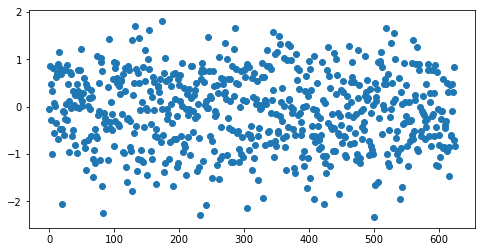

In [222]:
gbc_1 = optimize(gbc, gbc_params, Xr2_train, Xr2_test, Y_2_train, Y_2_test)

Optimal parameters: {'C': 1, 'gamma': 0.12, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.4561386121555704
ROC-AUC score: 0.7290072010631612
[[248  95]
 [ 75 208]]


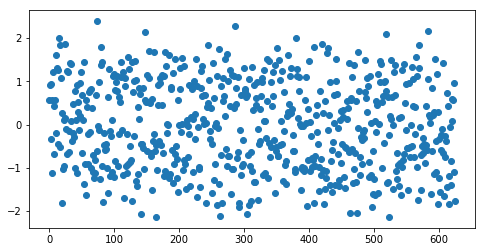

In [221]:
svc_1 = optimize(svc, svc_params, Xr2_train, Xr2_test, Y_2_train, Y_2_test)

In [228]:
def optimize2(clf, params, data, features, rand):
    
    predictors = data.loc[:, features]
    targets = data.loc[:, 'high_death_rate']
    
    data_train, data_test, Y_train, Y_test = train_test_split(predictors, targets, test_size=.2,
                                                                stratify=targets, random_state=rand)
    X_train = pd.DataFrame(robust.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                           index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
    X_train['urban_inf'] = data_train['urban_inf']
    
    X_test = pd.DataFrame(robust.fit_transform(data_test.drop(['urban_inf'], axis=1)),
                       index=data_test.index, columns=data_test.drop(['urban_inf'], axis=1).columns)
    X_test['urban_inf'] = data_test['urban_inf']

    X_train = pd.get_dummies(X_train, prefix='urb_inf_', columns=['urban_inf'])
    X_test = pd.get_dummies(X_test, prefix='urb_inf_', columns=['urban_inf'])


    model = GridSearchCV(clf, param_grid=params, cv=4, scoring=matthews)
    model.fit(X_train, Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    preds = model.predict(X_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(model.best_estimator_.decision_function(X_test))
    plt.scatter(residuals.index, residuals)
    return model

In [229]:
df = data.drop(['death_rate', 'numeric'], axis=1)

Optimal parameters: {'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
Matthews score: 0.39987844096605024
ROC-AUC score: 0.6998114743120873
[[251  92]
 [ 94 189]]


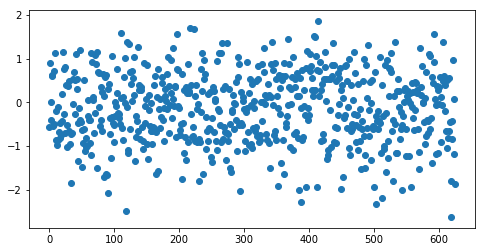

In [230]:
gbc2 = optimize2(gbc, gbc_params, df, features2, 37)

Optimal parameters: {'C': 4, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.4673331274241291
ROC-AUC score: 0.7347041795011796
[[241 102]
 [ 66 217]]


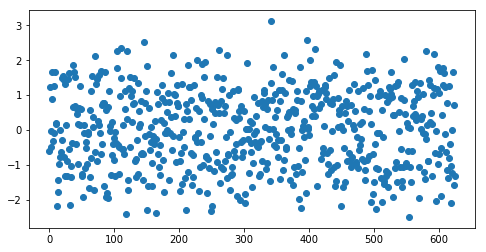

In [231]:
svc2 = optimize2(svc, svc_params, df, features2, 37)

Experimentation found cross-validation with 4 folds to work best. Gradient boosting is not stable with respect to the split in the dataset, whereas support vector is. The results are very close to those obtained when the unscaled dataset was used for feature selection. In both cases the 

In [236]:
svc3 = SVC(C=1, gamma=.12, kernel='linear', tol=1e-7)
svc3.fit(Xr2_train, Y_2_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.12, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=1e-07, verbose=False)

In [237]:
feature_rank = zip(Xr2_train.columns, svc3.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}'.format(f, r))

unemployment :  0.98015
crime        :  0.71538
urb_inf__1   :  0.50996
urb_inf__4   :  0.46740
unemp_change :  0.31416
urb_inf__10  :  0.29202
urb_inf__11  :  0.22026
urb_inf__7   :  0.15704
median_age   :  0.15343
vets         :  0.14107
urb_inf__2   :  0.09748
urb_inf__12  :  0.00751
urb_inf__8   : -0.02618
degree+      : -0.07020
pov_change   : -0.12578
foreign_07   : -0.15419
urb_inf__3   : -0.19384
urb_inf__6   : -0.21813
urb_inf__9   : -0.33255
hh_afr_am    : -0.55512
urb_inf__5   : -0.98098
